### Import

In [1]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeOsaka
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from nftopt import nakanishi_fujii_todo

In [2]:
hamiltonian = SparsePauliOp.from_list(
                [("IIII", -0.0996), 
                ("IIIZ", 0.1711), 
                ("IIZI", 0.1711), 
                ("IZII", -0.2225), 
                ("ZIII", -0.2225), 
                ("IIZZ", 0.1686), 
                ("IZIZ", 0.1205), 
                ("ZIIZ", 0.1658), 
                ("IZZI", 0.1658), 
                ("ZIZI", 0.1205), 
                ("ZZII", 0.1743), 
                ("XYYX", 0.0453), 
                ("YXXY", 0.0453), 
                ("YYXX", -0.0453), 
                ("XXYY", -0.0453)]
            )

# hamiltonian = SparsePauliOp.from_list(
#     [("IIII", -0.81054), 
#      ("IZIZ", 0.16614), 
#      ("ZIZI", 0.16892), 
#      ("ZIII", 0.17218), 
#      ("IIZI", 0.17218), 
#      ("IZII", -0.22573), 
#      ("IIIZ", -0.22573), 
#      ("ZZII", 0.12091), 
#      ("IIZZ", 0.12091), 
#      ("ZIIZ", 0.166145), 
#      ("IZZI", 0.166145), 
#      ("YYYY", 0.04523), 
#      ("XXYY", 0.04523), 
#      ("YYXX", 0.04523), 
#      ("XXXX", 0.04523)]
# )
# print(hamiltonian.to_matrix())

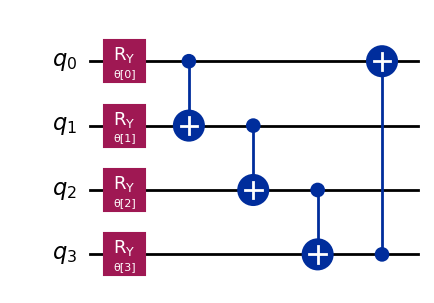

In [3]:
num_qubits = 4

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

ansatz.decompose().draw('mpl')

In [4]:
num_params = ansatz.num_parameters
num_params

4

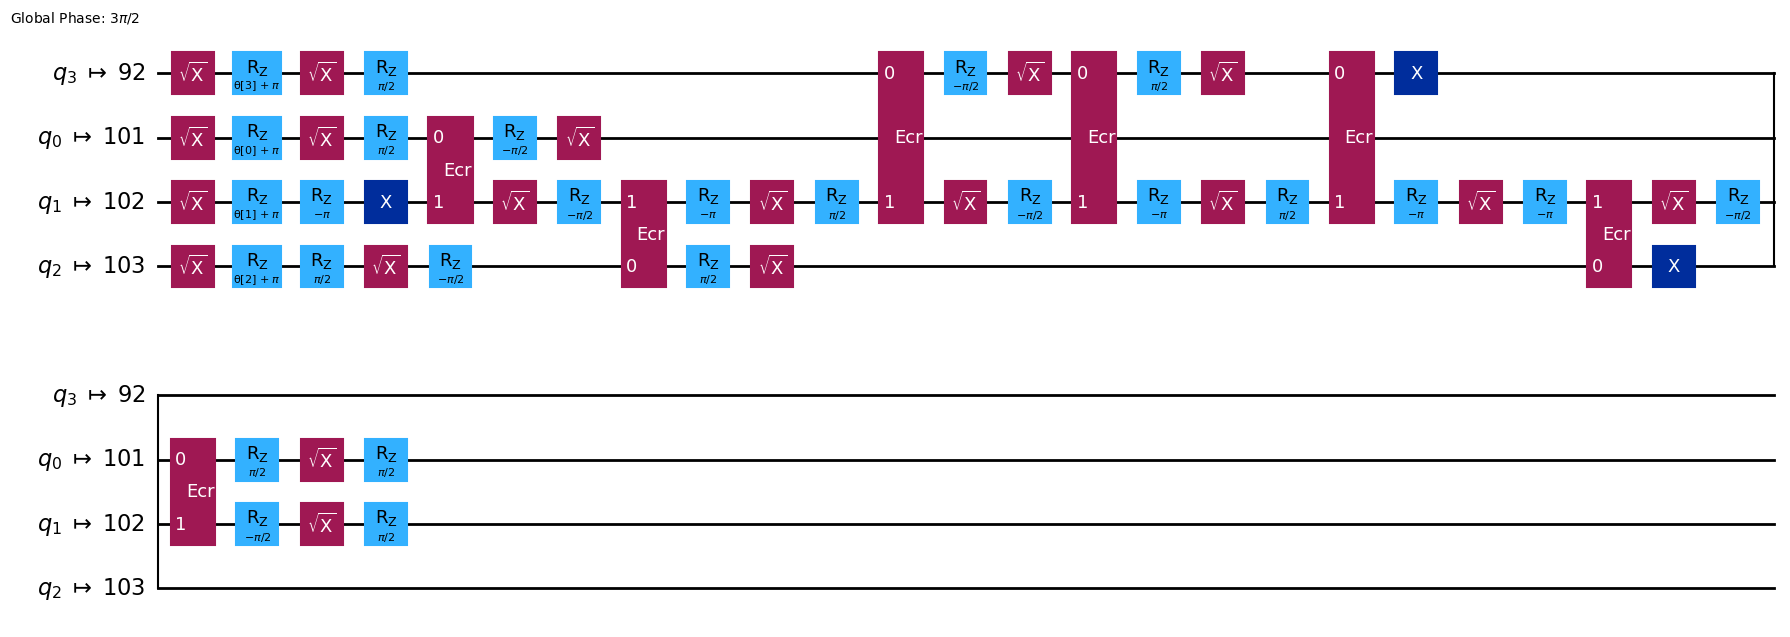

In [5]:
backend_answer = FakeOsaka()
optimization_level_answer = 2
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)
isa_circuit.draw('mpl', idle_wires=False,)

In [6]:
# Define our Hamiltonian
hamiltonian_isa = hamiltonian.apply_layout(layout=isa_circuit.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [7]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)

    print(f"Iters. done: {callback_dict['iters']} [Current cost: {energy}]")
    return energy, result

In [8]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
x0

array([0.42859038, 2.6060971 , 6.20144282, 5.33988517])

In [11]:
# backend = FakeOsaka()
backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method='cobyla',
        options={'maxiter': 30})

KeyError: '(103,) not in target.'

### NFT Optimizer

In [25]:
# backend = FakeOsaka()
backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method=nakanishi_fujii_todo,
        options={'maxiter': 30})

-0.9344823754882812
-0.49124780273437496
-1.4994309887695314
-0.7256880761718753
-1.4811255810546875
-0.9995012744140624
-1.2670102612304683
-1.2589482373046876
-1.8408137866210934
-1.184166940917969
-1.1554865502929692
-1.0464969287109374
-1.0448009667968752
-1.1218419409179687
-1.1158672607421871
-1.5458713818359378
-1.5431250488281254
-1.1784244653320315
-1.155640458984375
-1.0365614794921876
-1.0760775048828128
-1.1068922241210937
-1.1460502221679687
-1.5384490795898436
-1.5399158422851562
-1.1612327270507814
-1.1730129467773438
-1.0453092016601562
-1.052876784667969
-1.123300859375
-1.105276169433594
-1.5487541064453125
-1.5503680322265625
-1.1644681567382809
-1.1786881665039062
-1.0796417431640626
-1.0456175537109376
-1.1252601171875
-1.1123717749023436
-1.5554254736328126
-1.5473919042968751
-1.1636413061523438
-1.1569277221679688
-1.0464938134765625
-1.0758082910156253
-1.1136508593749999
-1.1218388452148433


KeyboardInterrupt: 

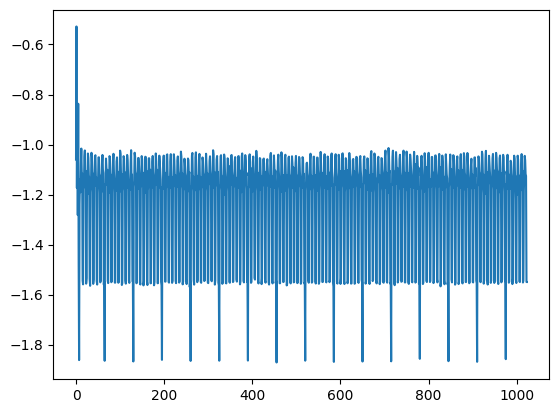

In [ ]:
plt.plot(callback_dict['cost_history'])

### COBYLA Optimizer

In [33]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


# backend = FakeOsaka()
backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    # estimator.options.default_shots = 10000

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method='cobyla',
        options={'maxiter': 30})

Iters. done: 1 [Current cost: -0.5339847656250001]
Iters. done: 2 [Current cost: -0.368340283203125]
Iters. done: 3 [Current cost: -0.533520263671875]
Iters. done: 4 [Current cost: -0.5149858886718751]
Iters. done: 5 [Current cost: -0.6833519042968751]
Iters. done: 6 [Current cost: -0.723322900390625]
Iters. done: 7 [Current cost: -1.050956689453125]
Iters. done: 8 [Current cost: -1.068693603515625]
Iters. done: 9 [Current cost: -0.9150162109375002]
Iters. done: 10 [Current cost: -0.923300341796875]
Iters. done: 11 [Current cost: -1.0511765624999998]
Iters. done: 12 [Current cost: -0.74929052734375]
Iters. done: 13 [Current cost: -0.9165070800781248]
Iters. done: 14 [Current cost: -1.0398024902343754]
Iters. done: 15 [Current cost: -1.0346369140625]
Iters. done: 16 [Current cost: -1.111166015625]
Iters. done: 17 [Current cost: -1.1231132324218753]
Iters. done: 18 [Current cost: -1.1190150878906249]
Iters. done: 19 [Current cost: -1.1278097656249997]
Iters. done: 20 [Current cost: -1.08

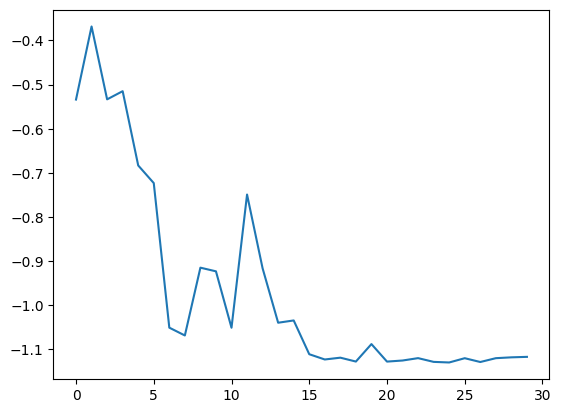

In [34]:
plt.plot(callback_dict['cost_history'])

### Nelder-Mead Optimizer

In [37]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


# backend = FakeOsaka()
backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    # estimator.options.default_shots = 10000

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method='nelder-mead',
        options={'maxiter': 30})

Iters. done: 1 [Current cost: -0.533906005859375]
Iters. done: 2 [Current cost: -0.4941262207031249]
Iters. done: 3 [Current cost: -0.5310747558593749]
Iters. done: 4 [Current cost: -0.5311656250000001]
Iters. done: 5 [Current cost: -0.5399377441406249]
Iters. done: 6 [Current cost: -0.495089697265625]
Iters. done: 7 [Current cost: -0.5264425292968751]
Iters. done: 8 [Current cost: -0.5232261230468751]
Iters. done: 9 [Current cost: -0.532717431640625]
Iters. done: 10 [Current cost: -0.534707275390625]
Iters. done: 11 [Current cost: -0.536932275390625]
Iters. done: 12 [Current cost: -0.5352479492187501]
Iters. done: 13 [Current cost: -0.5483221191406249]
Iters. done: 14 [Current cost: -0.5619662109375]
Iters. done: 15 [Current cost: -0.554233740234375]
Iters. done: 16 [Current cost: -0.5522159667968751]
Iters. done: 17 [Current cost: -0.575648828125]
Iters. done: 18 [Current cost: -0.6008347167968751]
Iters. done: 19 [Current cost: -0.61635947265625]
Iters. done: 20 [Current cost: -0.68

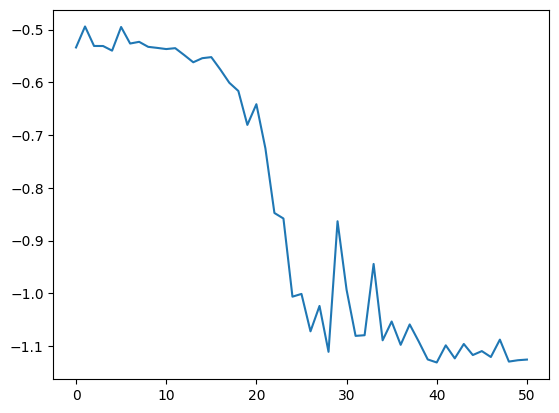

In [38]:
plt.plot(callback_dict['cost_history'])

In [14]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


# backend = FakeOsaka()
backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    # estimator.options.default_shots = 10000

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method='cobyla',
        options={'maxiter': 30})

KeyError: '(103,) not in target.'

In [1]:
from qiskit.algorithms.minimum_eigensolvers import VQE  # new import!!!
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
 
ansatz = TwoLocal(2, 'ry', 'cz')
opt = SPSA(maxiter=50)
 
# shot-based simulation
estimator = Estimator(options={"shots": 2048})
vqe = VQE(estimator, ansatz, opt)
 
# another option
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 42})
vqe = VQE(aer_estimator, ansatz, opt)
 
hamiltonian = SparsePauliOp.from_list([("XX", 1), ("XY", 1)])
result = vqe.compute_minimum_eigenvalue(hamiltonian)
 
print(result.eigenvalue)

/tmp/ipykernel_79538/3952590743.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE  # new import!!!


-0.970703125


In [1]:
from qiskit.algorithms.minimum_eigensolvers import VQE  # new import!!!
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
 
ansatz = TwoLocal(2, 'ry', 'cz')
opt = SPSA(maxiter=50)
 
# shot-based simulation
estimator = Estimator(options={"shots": 2048})
vqe = VQE(estimator, ansatz, opt)
 
# another option
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 42})
vqe = VQE(aer_estimator, ansatz, opt)
 
hamiltonian = SparsePauliOp.from_list([("XX", 1), ("XY", 1)])
result = vqe.compute_minimum_eigenvalue(hamiltonian)
 
print(result.eigenvalue)

ModuleNotFoundError: No module named 'qiskit.algorithms'